In [1]:

import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
import sys

# usage example(train for 100 epoch use past model) : python clm_3.py train 100
# sample some short poems : python clm_3.py load 0 

/Users/chenlimin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

# This function slices the unwanted text (introduction, etc.) at the beginning of the txt file 
# It takes a string 'my_str', and delete everything before the specified 'sub' 
def slicer_front(my_str,sub):
  index=my_str.find(sub)
  if index !=-1 :
        return my_str[index:] 
  else :
        raise Exception('Sub string not found!')

# This function slices the unwanted text (introduction, etc.) at the end of the txt file 
def slicer_back(my_str,sub):
  index=my_str.find(sub)
  if index !=-1 :
        return my_str[:index] 
  else :
        raise Exception('Sub string not found!')
        
        
# writ a function to read in data from a url 
def get_soup(target_url):
    r = requests.get(target_url)
    soup = BeautifulSoup(r.text, "html.parser")
    return soup

DJ = get_soup('http://www.gutenberg.org/cache/epub/21700/pg21700.txt')
# Clean preface, conclusion and titles
DJ_txt = slicer_back(slicer_front(DJ.get_text(),'I want a hero: an uncommon want,'),'End of the Project Gutenberg EBook') # Delete the preface and conclusion
DJ = DJ_txt.split('\r\n\r\n')
DJ_c = [i for i in DJ if len(i)> 50 and len(i)<500]

corpus = DJ_c

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len( tokenizer.word_index ) + 1
total_words

input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)
        
sequence_lengths = list()
for x in input_sequences:
    sequence_lengths.append( len( x ) )
max_sequence_len = max( sequence_lengths )
max_sequence_len

input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen=max_sequence_len+1, padding='pre'))
x, y = input_sequences[:, :-1], input_sequences[:, -1]
y = keras.utils.to_categorical(y, num_classes=total_words)

dropout_rate = 0.2
activation_func = keras.activations.relu

In [11]:
# in jupyter notebook we can only set it to load instead of sys.argv
mode = 'load'

In [3]:
# retrain model
if mode == 'retrain':
    SCHEMA = [
    
        Embedding( total_words ,128, input_length=max_sequence_len ),
        LSTM( 64 ) ,
        Dropout(dropout_rate),
        Dense( 64 , activation=activation_func ) ,
        Dropout(dropout_rate),
        Dense( total_words, activation=tf.nn.softmax )
    
    ]
    
    model = keras.Sequential(SCHEMA)
    model.compile(
        optimizer=keras.optimizers.Adam() ,
        loss=keras.losses.categorical_crossentropy ,
        metrics=[ 'accuracy' ]
    )
    
    model.summary()
    
    
    checkpoint = [ModelCheckpoint(filepath='2_TY_1Layer_LongCorp.hdf5',period=5)]
    
    history = model.fit(
        x,
        y,
        batch_size=32 ,
        epochs=sys.argv[2],
        callbacks=checkpoint
    )
    
    
    # save model
    model_json = model.to_json()
    with open("2_TY_1Layer_4629_LongerCorp.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("2_TY_1Layer_4629_LongerCorp.h5")
    print("Saved model to disk")
    
    # Save Accuracy
    result = pd.DataFrame({'accuracy':history.history['acc'],'loss':history.history['loss']})
    result.to_csv(r'2_TY_1Layer_4629_LongerCorp_Accuracy.csv')


In [12]:
# load the trained mode
if mode == 'load':
    # Load Model
    from tensorflow.keras.models import model_from_json
    # load json and create model
    json_file = open('2_TY_1Layer_4629_LongerCorp.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model =  keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("2_TY_1Layer_4629_LongerCorp.h5")
    print("Loaded model from disk")
            
        
    def predict(seed_text , seed=10 ):
    
        for i in range( seed ):
    
            token_list = tokenizer.texts_to_sequences([seed_text])[0]
            token_list = pad_sequences([token_list], maxlen=
            max_sequence_len , padding='pre')
            predicted = loaded_model.predict_classes(token_list, verbose=0 )
            output_word = ""
            for word, index in tokenizer.word_index.items():
                if index == predicted:
                    output_word = word
                    break
            seed_text += " " + output_word
    
        return seed_text


Loaded model from disk


In [7]:
# keep train mode
if mode == 'train':
    
    from tensorflow.keras.models import model_from_json
    # load json and create model
    json_file = open('2_TY_1Layer_4629_LongerCorp.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model =  keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("2_TY_1Layer_4629_LongerCorp.h5")
    print("Loaded model from disk")

    checkpoint = [ModelCheckpoint(filepath='2_TY_1Layer_LongCorp.hdf5',period=5)]
    model = loaded_model    
    model.compile(
    optimizer=keras.optimizers.Adam() ,
    loss=keras.losses.categorical_crossentropy ,
    metrics=[ 'accuracy' ]
    )
    # model batch size changes by the time step
    # we adjust it by ourselves from 32 to 64 to 32*50 as we find that the model cannot find a proper gradient as the time goes
    # se we need to broaden the batch size for a more stable gradient descent
    history = model.fit(
        x,
        y,
        batch_size=32*50 ,
        epochs=int(sys.argv[2]),
        callbacks=checkpoint
    )
    
    
    # save model
    model_json = model.to_json()
    with open("2_TY_1Layer_4629_LongerCorp.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("2_TY_1Layer_4629_LongerCorp.h5")
    print("Saved model to disk")
    
    print(history.history.keys())    
    # Save Accuracy
    result = pd.DataFrame({'accuracy':history.history['accuracy'],'loss':history.history['loss']})
    result.to_csv(r'2_TY_1Layer_4629_LongerCorp_Accuracy.csv')





In [8]:
# inference of model
def predict(seed_text , seed=10 ):

    for i in range( seed ):

        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=
        max_sequence_len , padding='pre')
        predicted = loaded_model.predict_classes(token_list, verbose=0 )
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text

def test():
    print( 
      predict( 
        input( 'Enter some starter text ( I want ... ) : ') , 
        int( input( 'Enter the desired length of the generated sentence : '))  
      ) 
    )
    

In [14]:
# show a demp
test()


Enter some starter text ( I want ... ) : wine
Enter the desired length of the generated sentence : 7
wine was commonest and mostly in men 


In [ ]:
# pefformance plot


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

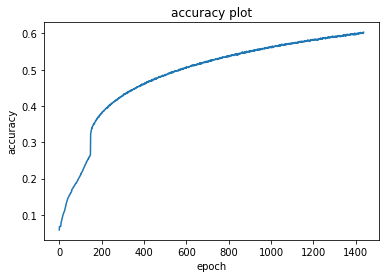

In [16]:
a=pd.read_csv('model_result.csv')

plt.title('accuracy plot')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(a['accuracy'])

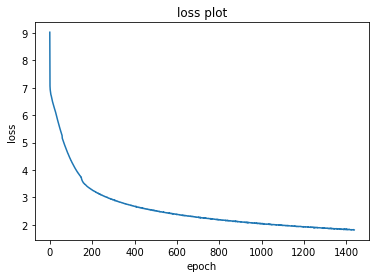

In [17]:
plt.title('loss plot')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(a['loss'])